In [3]:
%matplotlib inline

import re
import numpy
import json
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
main_folder = "/Users/ofek/PCA_CF/compareToDva/"
model_file_path = main_folder + "modelFile_main_201811060700.json"
model_low_file_path = main_folder + "modelFile_main_201811060700_low.json"
# choose the number of values per ad in the new model
K = 668

tmp_pca_matrix_file_path = main_folder + "tmp_pca_matrix.tmp"
tmp_low_matrix_file_path = main_folder + "tmp_low_matrix.tmp"

ad_vec_pattern = re.compile(r".*\"creative_id\.([0-9]*)\":\[(.*)\].*")  # for ad vectors count
ad_vec_sub_pattern = re.compile(r"(.*\"creative_id\.[0-9]*\":\[).*(\].*)")  # for vector substitution

In [57]:
# *******
# methods
# =======

def get_user_features(model_file_path):
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return json.loads(''.join(ret))
            else:
                if ok_to_write:
                    line_list.append(line)
    return None


def getUserFeaturesVector(label_vectors, row_idx, user_features):
    labels_count = 0
    for feature_name in user_features:
        label_count = 0
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it, it will be added later
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue
        for label in feature:
            label_vectors[row_idx] = numpy.array(feature[label]);
            row_idx += 1
            label_count += 1
        print("Done for feature_name [" + feature_name + "] label_count [" + str(label_count) + "]")
        labels_count += label_count
    return labels_count


# for features that are added together before multiplication
def getListUserFeatureVector(label_vectors, row_idx, user_features, feature_name, sub_feature_name = None):
    labels_count = 0
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # get NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    neutral_label_vec = numpy.array(neutral_label_map[neutral_label])
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    for label in list_feature:
        list_feature_vector = numpy.array(list_feature[label])
        list_feature_vector = numpy.add(list_feature_vector, neutral_label_vec)
        label_vectors[row_idx] = list_feature_vector
        row_idx += 1
        labels_count += 1

    print("Done for feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels_count [" + str(labels_count) + "]")
    return labels_count


def generate_label_vectors_matrix(model_file_path):
    user_features = get_user_features(model_file_path)
    max_num_of_rows = numpy.sum([len(user_features[feature]) for feature in user_features])
    print("max_num_of_rows [" + str(max_num_of_rows) + "]")
    # count how many NEUTRAL vectors there are
    num_of_neutral_vectors = 0
    for feature_name in user_features:
        feature = user_features[feature_name]
        num_of_neutral_vectors += len([p for p in feature.keys() if "NEUTRAL" in p])
    label_vectors_matrix = numpy.zeros(shape=(max_num_of_rows - num_of_neutral_vectors, 970))

    row_idx = 0
    row_idx += getUserFeaturesVector(label_vectors_matrix, row_idx, user_features)
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp5_allMappi")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "externalFeature", "exp1_userCategory")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yic_mv")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "yct_c_mv_w")
    row_idx += getListUserFeatureVector(label_vectors_matrix, row_idx, user_features, "userSignal")

    return label_vectors_matrix


In [58]:
# *********
# algorithm
# =========

# get number of ads in the model
num_of_ads = 0
with open(model_file_path, 'r') as model_file:
    for line in model_file:
        if ad_vec_pattern.match(line):
            num_of_ads += 1

print("ad num [" + str(num_of_ads) + "]")

# prepare the matrix with all the ad vectors in rows
X = numpy.zeros(shape=(num_of_ads, 970))
creative_ids = []
with open(model_file_path, 'r') as model_file:
    ad_idx = 0
    for line in model_file:
        m = ad_vec_pattern.match(line)
        if m:
            creative_id = m.group(1)
            creative_ids.append(creative_id)
            X[ad_idx] = numpy.fromstring(m.group(2), sep=",")
            ad_idx += 1

assert ad_idx == num_of_ads
assert numpy.sum(X[:,968]) == 0  # all values in col are 0
assert numpy.sum(X[:,969]) == X.shape[0]  # all values in col are 1

# generate the label vectors
label_vectors_matrix = generate_label_vectors_matrix(model_file_path)

# the last col is the label vector bias and is equal in all label vectors
# argmax - returns the index of the maximum value along the axis
# the bias is taken from one of the "day" user feature vector (any of them)
user_vector_bias = label_vectors_matrix[(label_vectors_matrix[:, 969] != 1.0).argmax(axis=0), 969]

# all values in col are user_vector_bias
# 8 amounts to the number of "day" feature labels - (1-7) + 1 UNKNOWN label. located here label_vectors_matrix[15460:15470,:]
# Haifa choose to add the bias in the "day" feature. Since it is only in one feature, any user vector that is generated will have
# the bias in the last value of the vector.
assert numpy.sum(label_vectors_matrix[:,969] != 1.0) == 8

# calculate PCA
# 1) append the matrices
X_for_pca = numpy.concatenate((X, label_vectors_matrix), axis=0)

assert X_for_pca.shape[1] == 970

# 2) remove the last two cols which contain 0 and 1 for bias
X_for_pca = numpy.delete(X_for_pca, 969, 1)  # all ones
X_for_pca = numpy.delete(X_for_pca, 968, 1)  # all zeros

# 3) calculate the covariance matrix Sigma
Sigma = numpy.matmul(numpy.transpose(X_for_pca), X_for_pca) / X_for_pca.shape[0]  # (1/|rows in X|) * (X' * X)
UX, SX, _ = numpy.linalg.svd(Sigma)  # [U S V] = svd(Sigma);

# use PCA UX matrix to reduce the dimension of the ad vectors
# calculate preserved variance percentage for declaration in the model file
preserved_variance_pct = (numpy.sum(SX[0:K]) * 100.0) / numpy.sum(SX)
# reduce the dimension of the ad vectors
X_low = numpy.matmul(X[:, 0:968], UX[:, 0:K])  # Z = X * U(:, 1:K);

assert X_low.shape[1] == K
assert X_low.shape[0] == X.shape[0]

# add a ones col for user vector bias addition
X_low = numpy.concatenate((X_low, numpy.ones((X_low.shape[0], 1))), axis=1)

assert X_low.shape[1] == (K + 1)
assert X_low.shape[0] == X.shape[0]
assert X_low.shape[0] == num_of_ads

print("Done")


ad num [260042]
max_num_of_rows [28072]
Done for feature_name [day] label_count [8]
Done for feature_name [local_hour] label_count [25]
Done for feature_name [sectionId] label_count [11634]
Done for feature_name [state] label_count [3671]
Done for feature_name [age] label_count [126]
Done for feature_name [gender] label_count [4]
Done for feature_name [externalFeature] sub_feature_name [exp5_allMappi] labels_count [2924]
Done for feature_name [externalFeature] sub_feature_name [exp1_userCategory] labels_count [20]
Done for feature_name [yic_mv] sub_feature_name [None] labels_count [96]
Done for feature_name [yct_c_mv_w] sub_feature_name [None] labels_count [1035]
Done for feature_name [userSignal] sub_feature_name [None] labels_count [8524]
Done


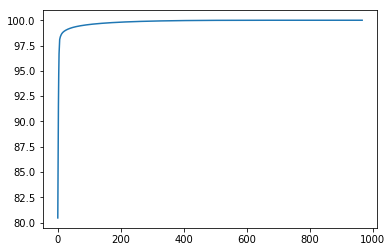

In [59]:
# plot the variance preservance
sx_all = numpy.sum(SX)
df_map = {
    'k': range(1, 968),
    'variance': [((numpy.sum(SX[0:k]) * 100.0) / sx_all) for k in range(1, 968)]
}
sx_df = pd.DataFrame.from_dict(df_map)
#print(sx_df)
#sx_df.plot(x='k', y='variance', style='o')
plt.plot(sx_df['variance'])

In [8]:
# **********************************
# write the new model to a json file
# ==================================

# copy all the lines in the file
open(model_low_file_path, 'w').close()  # delete output file content
open(tmp_pca_matrix_file_path, 'w').close()  # delete the content of the tmp pca matrix file
open(tmp_low_matrix_file_path, 'w').close()  # delete the content of the tmp X_low matrix file
with open(model_file_path, 'r') as model_file, open(model_low_file_path, 'a') as model_low_file:
    # pca data is inserted before the feature vectors section starts
    while True:
        line = model_file.readline()
        if "\"user\":{\n" in line:
            break
        model_low_file.write(line)
    model_low_file.write("\"pca\":{\n")
    model_low_file.write("\"usedVecDim\": \"" + str(K) + "\",\n")
    model_low_file.write("\"preservedVariancePct\": \"" + str(preserved_variance_pct) + "\",\n")
    model_low_file.write("\"userVectorBias\": \"" + str(user_vector_bias) + "\",\n")
    model_low_file.write("\"UX\": \n")
    with open(tmp_pca_matrix_file_path, 'w') as tmp_pca_matrix_file:
        numpy.savetxt(tmp_pca_matrix_file, UX, delimiter=",", fmt="%1.6E")
    model_low_file.write("[\n")
    with open(tmp_pca_matrix_file_path, 'r') as tmp_pca_matrix_file:
        count = 0
        for pca_matrix_row in tmp_pca_matrix_file:
            count += 1
            model_low_file.write("[" + pca_matrix_row.strip().replace("E-0", "E-").replace("E+0", "E+") + "]" + (",\n" if count < 968 else "\n"))
    # delete the tmp file
    open(tmp_pca_matrix_file_path, 'w').close()
    model_low_file.write("]\n")
    model_low_file.write("},\n")  # close for pca section

    # feature vectors remain as they are (original dimension of 970)
    model_low_file.write("\"user\":{\n")
    while True:
        line = model_file.readline()
        model_low_file.write(line)
        if "\"ad\":" in line:
            break

    # write all the new lower dimension creatives' vectors
    # in bash: `cat lfmModel12_201809010945.json.gz | gzip -cd | grep "\"creative_id\.[0-9]*\":\[" | sed -E -e "s/.*\"creative_id\.([0-9]*)\":\[(.*)\].*/\1 \2/g" | tr ',' ' ' > lfmModel12_201809010945.m`

    with open(tmp_low_matrix_file_path, 'w') as tmp_low_matrix_file:
        numpy.savetxt(tmp_low_matrix_file, X_low, delimiter=",", fmt="%1.6E")
    with open(tmp_low_matrix_file_path, 'r') as tmp_low_matrix_file:
        ad_idx = 0
        while True:
            line = model_file.readline()
            if not line:
                assert not tmp_low_matrix_file.readline()
                break
            m = ad_vec_sub_pattern.match(line)
            if m:
                X_low_row = tmp_low_matrix_file.readline()
                X_low_row = X_low_row.replace('\n', '').replace(' ', '').replace("E-0", "E-").replace("E+0", "E+")
                new_ad_vector_line = m.group(1) + X_low_row + m.group(2) + "\n"
                # TODO: sanity, make sure the line is correct using the `ad_vec_pattern` regex
                ms = ad_vec_pattern.match(new_ad_vector_line)
                if ms:
                    ad_idx += 1
                    model_low_file.write(new_ad_vector_line)
                else:
                    print "ERROR with line [" + new_ad_vector_line + "]"
            else:
                model_low_file.write(line)

    # delete the tmp file
    open(tmp_low_matrix_file_path, 'w').close()

print("Done in [" + str(int(time.time()) - start_time_sec) + "] sec")
print("Number of written ads/number of ads in original model [" + str(ad_idx) + "/" + str(num_of_ads) + "]")


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("ERROR with line [" + new_ad_vector_line + "]")? (<ipython-input-8-fdde7d339e59>, line 65)

In [52]:
# ************************************
# generate random user profile vectors
# ====================================

num_of_profiles_to_generate = 500

def get_user_features_string():
    with open(model_file_path, 'r') as model_file:
        line_list = []
        ok_to_write = False
        for line in model_file:
            if "\"user\":" in line:
                line_list.append("{")
                ok_to_write = True
            elif "\"ad\":" in line:
                line_list.pop()
                line_list.append("}")
                ret = ''.join(line_list)
                return ''.join(ret)
            else:
                if ok_to_write:
                    line_list.append(line)


def coin_toss(p=.5):
    return True if random.random() < p else False


def get_user_features_vector(user_features):
    feature_vector = numpy.ones(970)
    for feature_name in user_features:
        feature = user_features[feature_name]
        # if the feature contains any label with "NEUTRAL" skip it
        if len([p for p in feature.keys() if "NEUTRAL" in p]) > 0:
            continue;
        rand_index = random.randint(0, len(feature.keys()) - 1)
        chosen_label = list(feature)[rand_index]
        #print("feature_name [" + feature_name + "] label [" + chosen_label + "]")
        feature_vector = numpy.multiply(feature_vector, feature[chosen_label])

    #print numpy.array2string(feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return feature_vector


# for features that are added together before multiplication
def get_list_user_feature_vector(user_features, feature_name, sub_feature_name = None, maxNumOfLabels = 100):
    considered_labels = []
    list_feature_vector = numpy.zeros(970)
    list_feature = user_features[feature_name]
    if len(list_feature) <= 0:
        raise Exception("Error with feature_name [" + feature_name + "]")
    if sub_feature_name is not None:
        # filter out any label that does not contain the sub_feature_name
        list_feature = { k: v for k, v in list_feature.items() if sub_feature_name in k }
        if len(list_feature) <= 0:
            raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")

    # add NEUTRAL vector
    neutral_label_map = { k: v for k, v in list_feature.items() if "NEUTRAL" in k }
    if len(neutral_label_map) is not 1:
        raise Exception("Error with feature_name [" + feature_name + "] and sub_feature_name [" + sub_feature_name + "]")
    neutral_label = list(neutral_label_map.keys())[0]
    considered_labels.append(neutral_label)
    list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[neutral_label]))
    # remove neutral label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "NEUTRAL" not in k }

    # choose UNKNOWN
    if coin_toss(0.05):
        # in this case only UNKNOWN (and NEUTRAL) should be picked
        unknown_label_map = { k: v for k, v in list_feature.items() if "UNKNOWN" in k }
        unknown_label = list(unknown_label_map.keys())[0]
        considered_labels.append(unknown_label)
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(list_feature[unknown_label]))
        #print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
        #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
        return list_feature_vector

    # remove UNKNOWN label from list_feature
    list_feature = { k: v for k, v in list_feature.items() if "UNKNOWN" not in k }

    # choose max maxNumOfLabels labels from list_feature
    labels = random.sample(list(list_feature), random.randint(1, min(len(list_feature), maxNumOfLabels)))
    considered_labels.append(labels)
    vector_values = [list_feature[label] for label in labels]

    for vector_value in vector_values:
        list_feature_vector = numpy.add(list_feature_vector, numpy.array(vector_value))

    #print("feature_name [" + feature_name + "] sub_feature_name [" + str(sub_feature_name) + "] labels " + str(considered_labels))
    #print numpy.array2string(list_feature_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
    return list_feature_vector


def generateUserVector(user_features):
    user_vector = numpy.ones(970)

    user_vector = numpy.multiply(user_vector, get_user_features_vector(user_features))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "externalFeature", "exp5_allMappi"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "externalFeature", "exp1_userCategory"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "yic_mv"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "yct_c_mv_w"))
    user_vector = numpy.multiply(user_vector, get_list_user_feature_vector(user_features, "userSignal"))

    return user_vector

user_features = json.loads(get_user_features_string())
user_vectors_mat = numpy.empty((0,970), int)
for i in range(num_of_profiles_to_generate):
    print("Generating user vector [" + str(i) + "]")
    user_vector = generateUserVector(user_features)
    user_vectors_mat = numpy.append(user_vectors_mat, [user_vector], axis=0)

print("")
print(user_vectors_mat)

print("")
print("user_vectors_mat dim [" + str(user_vectors_mat.shape[0]) + "X" + str(user_vectors_mat.shape[1]) + "]")

# user_vectors_df = pd.DataFrame({'Column1':data[:,0],'Column2':data[:,1]})
# print(user_vectors_df)


Generating user vector [0]
Generating user vector [1]
Generating user vector [2]
Generating user vector [3]
Generating user vector [4]
Generating user vector [5]
Generating user vector [6]
Generating user vector [7]
Generating user vector [8]
Generating user vector [9]
Generating user vector [10]
Generating user vector [11]
Generating user vector [12]
Generating user vector [13]
Generating user vector [14]
Generating user vector [15]
Generating user vector [16]
Generating user vector [17]
Generating user vector [18]
Generating user vector [19]
Generating user vector [20]
Generating user vector [21]
Generating user vector [22]
Generating user vector [23]
Generating user vector [24]
Generating user vector [25]
Generating user vector [26]
Generating user vector [27]
Generating user vector [28]
Generating user vector [29]
Generating user vector [30]
Generating user vector [31]
Generating user vector [32]
Generating user vector [33]
Generating user vector [34]
Generating user vector [35]
Ge

Generating user vector [293]
Generating user vector [294]
Generating user vector [295]
Generating user vector [296]
Generating user vector [297]
Generating user vector [298]
Generating user vector [299]
Generating user vector [300]
Generating user vector [301]
Generating user vector [302]
Generating user vector [303]
Generating user vector [304]
Generating user vector [305]
Generating user vector [306]
Generating user vector [307]
Generating user vector [308]
Generating user vector [309]
Generating user vector [310]
Generating user vector [311]
Generating user vector [312]
Generating user vector [313]
Generating user vector [314]
Generating user vector [315]
Generating user vector [316]
Generating user vector [317]
Generating user vector [318]
Generating user vector [319]
Generating user vector [320]
Generating user vector [321]
Generating user vector [322]
Generating user vector [323]
Generating user vector [324]
Generating user vector [325]
Generating user vector [326]
Generating use

In [15]:
# *****************************
# write user vectors to .m file
# =============================

user_vectors_file_path = "/Users/ofek/PCA_CF/compareToDva/modelFile_main_201811060700_user_vectors.m"

open(user_vectors_file_path, 'w').close()  # delete file content
with open(user_vectors_file_path, 'a') as user_vector_file:
    for user_vector in user_vectors_mat:
        user_vector = numpy.array2string(user_vector, max_line_width=numpy.inf, separator=' ',suppress_small=True)
        user_vector = ' '.join(user_vector.split())
        user_vector = re.sub(r'^\[|\]$', '', user_vector)
        user_vector_file.write(user_vector + "\n")

creatives_rank_real:
                   0          1          2         3          4          5    \
34246487761   8.452674  -3.858295 -10.906554 -3.173545  10.085726   2.741300   
34326707097  22.023628  -2.957028  -3.687733 -5.836767   7.517995  10.813921   
34326707098  20.579748  -2.038618  -3.676800 -5.506839   7.761795  10.928918   
34470108294   8.561707  -3.446354 -14.217971 -2.878607   4.600392   0.341496   
34326707099  22.140359  -3.048525  -4.736515 -5.558032   8.564549  11.771204   
34470108295   7.510476  -4.063464 -11.068456 -3.080023   2.558035  -1.242214   
34470108296   8.437355  -3.821279 -11.659919 -3.086706   3.690295   0.014798   
34476412049  16.824152  -6.819587 -16.467686 -1.523182  18.368145  11.427544   
34470108297   8.167096  -3.508943 -11.207639 -3.239502   4.786575   1.029751   
34470108298   7.906970  -7.100969 -19.995835 -2.003569  13.037728   8.488522   
34470108299  10.627238  -5.216060 -10.542007 -2.248991   7.098024   0.570097   
34508582080   9.356

creatives_rank_low:
                   0          1          2         3          4          5    \
34246487761   8.452364  -3.857273 -10.907569 -3.172697  10.085218   2.740665   
34326707097  22.023758  -2.963331  -3.697689 -5.831930   7.523358  10.814978   
34326707098  20.586650  -2.049902  -3.679133 -5.504904   7.765945  10.933465   
34470108294   8.583592  -3.456067 -14.213648 -2.877877   4.616399   0.348070   
34326707099  22.142851  -3.055319  -4.739252 -5.556717   8.568127  11.772911   
34470108295   7.534166  -4.074286 -11.064892 -3.080585   2.577197  -1.238527   
34470108296   8.464604  -3.832547 -11.652528 -3.085437   3.711834   0.018870   
34476412049  16.821768  -6.825095 -16.475000 -1.521482  18.359923  11.435591   
34470108297   8.190458  -3.517119 -11.199028 -3.234778   4.807249   1.032364   
34470108298   7.896802  -7.099973 -19.993643 -2.005658  13.029329   8.485278   
34470108299  10.632755  -5.212663 -10.533150 -2.248213   7.104322   0.568438   
34508582080   9.3670

creatives_rank_diff:
                  0         1         2         3         4         5    \
34246487761  0.000311  0.001021  0.001015  0.000848  0.000508  0.000635   
34326707097  0.000130  0.006302  0.009956  0.004837  0.005363  0.001058   
34326707098  0.006901  0.011284  0.002333  0.001935  0.004150  0.004547   
34470108294  0.021884  0.009713  0.004323  0.000730  0.016007  0.006575   
34326707099  0.002492  0.006793  0.002737  0.001315  0.003578  0.001708   
34470108295  0.023689  0.010821  0.003564  0.000562  0.019162  0.003687   
34470108296  0.027249  0.011268  0.007391  0.001269  0.021539  0.004072   
34476412049  0.002384  0.005507  0.007314  0.001700  0.008222  0.008046   
34470108297  0.023362  0.008176  0.008611  0.004724  0.020674  0.002613   
34470108298  0.010168  0.000997  0.002192  0.002089  0.008400  0.003243   
34470108299  0.005517  0.003397  0.008857  0.000778  0.006298  0.001659   
34508582080  0.010494  0.003506  0.003498  0.005505  0.010815  0.006287   
3091

rank_diff avg [0.004360381082834441]
rank_diff std [0.004349738679764181]
Correct first ad [99.2%]


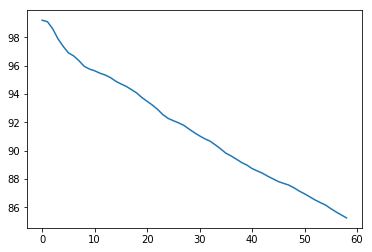

In [61]:
# ******************
# evaluate the model
# ==================

def sigmoid(x):
    return (1 / (1 + numpy.exp(-x)))

num_of_profiles_to_test = num_of_profiles_to_generate

if num_of_profiles_to_test > num_of_profiles_to_generate:
    print("You cannot test that number of profiles")
    exit(1)
    
user_vectors_mat = user_vectors_mat[0:num_of_profiles_to_test,:]
assert user_vectors_mat.shape[0] == num_of_profiles_to_test

# calculate rank_real
rank_real = numpy.matmul(X, numpy.transpose(user_vectors_mat))
creative_ids_vec = numpy.transpose(numpy.array([creative_ids]))  # [num_of_ads X 1]

creatives_rank_real = pd.DataFrame(data=rank_real,    # values
             index=creative_ids_vec[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

#creatives_rank_real = sigmoid(creatives_rank_real)

print("creatives_rank_real:")
print(creatives_rank_real)  # [num_of_ads X num_of_user_vectors]

# calculate rank_low
# remove biases from user_vectors_mat (last two colums are for bias)
user_vectors_mat_no_bias = user_vectors_mat[:,0:-2]
# dimentionality reduction on user_vectors_mat_no_bias
user_vectors_mat_no_bias_low = numpy.matmul(user_vectors_mat_no_bias, UX[:, 0:K])  # 210X968 * 968XK

# multiply each low user vector with all the creatives vectors
rank_low = numpy.matmul(X_low[:,0:-1], numpy.transpose(user_vectors_mat_no_bias_low)) + user_vector_bias;  # we use the user_vector_bias from the generated low model
creatives_rank_low = pd.DataFrame(data=rank_low[0:,0:],    # values
             index=creative_ids_vec[0:,0],    # 1st column as index
             columns=range(0, num_of_profiles_to_test))  # 1st row as the column names

#creatives_rank_low = sigmoid(creatives_rank_low)

print("creatives_rank_low:")
print(creatives_rank_low)  # [num_of_ads X num_of_user_vectors]

creatives_rank_diff = numpy.abs(creatives_rank_real - creatives_rank_low)
print("creatives_rank_diff:")
print(creatives_rank_diff)  # [num_of_ads X num_of_user_vectors]

print("rank_diff avg [" + str(numpy.mean(numpy.mean(creatives_rank_diff))) + "]")
print("rank_diff std [" + str(numpy.mean(numpy.std(creatives_rank_diff))) + "]")

correct_first_ad = creatives_rank_low.idxmax(axis=0, skipna=True) == creatives_rank_real.idxmax(axis=0, skipna=True)
print("Correct first ad [" + str(((correct_first_ad == 1).sum() * 100) / num_of_profiles_to_test) + "%]")

pct_values = []
correct_ads = (creatives_rank_low.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True)) == (creatives_rank_real.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True))
num_of_ads_in_auction_range = range(1,60)
for num_of_ads_in_auction in num_of_ads_in_auction_range:
    correct_ads_sliced = correct_ads.iloc[-num_of_ads_in_auction:,:]  # by default argsort is ascending
    pct_values.append(((correct_ads_sliced == 1).sum().sum() * 100) / (correct_ads_sliced.shape[0] * correct_ads_sliced.shape[1]))
    
gg = pd.DataFrame.from_dict({
    'num_of_ads_in_auction': num_of_ads_in_auction_range,
    'correct_ads_pct': pct_values
})

plt.plot(gg['correct_ads_pct'])


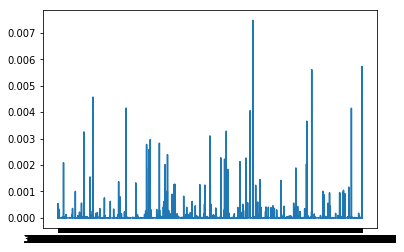

In [22]:
plt.plot(creatives_rank_diff.iloc[:100,0])

In [24]:
creatives_rank_low.idxmax(axis=0, skipna=True)

0      34186877847
1      34501790886
2      34326707097
3      34283412639
4      34231405421
5      34503095909
6      34087531258
7      34453797063
8      34499670810
9      33562623303
10     34510215785
11     34116853071
12     34503687182
13     34481370615
14     34454446337
15     34481383562
16     34502314156
17     34378031255
18     34118098276
19     34033628462
20     34458369420
21     34215413507
22     34384353424
23     34384363353
24     34391869199
25     34434283384
26     34231405421
27     34503687185
28     32636200279
29     34371788677
          ...     
470    34378036368
471    34488406047
472    34501353407
473    33721103440
474    34461734350
475    34475029915
476    34502474438
477    34371788756
478    34371788674
479    34384353424
480    34484800056
481    34475356428
482    33562623303
483    34481998056
484    34394684399
485    34501790886
486    34371788674
487    34434283384
488    34287962015
489    34476412045
490    34287962015
491    34484

In [25]:
creatives_rank_low.apply(lambda x: (x).index[(x).argsort()]).reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,34490327437,34384709875,34384709875,34384709875,34384709875,34490327437,34453844328,34232463056,34453797061,34384709875,...,34462028287,34384709875,34384709875,34490343887,34488042900,34489105814,34453844328,34239996317,34231941391,32717335112
1,34490338808,34384709874,34384709874,34384709874,34384709874,34490343887,34492867211,34239996317,34453797063,34384709874,...,34150182211,34384709874,34384709874,34490327437,34384709875,34488759253,34499406088,34231941391,34239996317,32516545713
2,34490343887,34453844328,34490338808,34453844328,34490350292,34490338808,34437992348,34231941391,34453797059,34490327437,...,34250998922,34489105814,34492867211,34490338808,34384709874,34489750038,34501767600,34232463056,34232463056,33609371729
3,34490350292,34488042900,34490343887,33629418944,34490338808,34490325330,34437992349,34490343887,34503248542,34490338808,...,33175053744,34489750038,34453844328,34490350292,34492867211,34499068859,34502303356,34481413756,32780568283,34033628462
4,34490338934,34502972261,34490350292,34453829845,34490327437,34490338934,34285293688,34490338808,34501622015,34490350292,...,34499485427,34488759253,34488042900,34490338934,34497400813,34499244084,34384709875,34490350292,34503082528,34030804494
5,34490341448,34502974157,34490327437,34122550310,34490338934,34490350292,34499485427,34490338934,34501353407,34490343887,...,34458371472,34499244084,34329408158,34490341448,34418966311,34499244083,34384709874,34490338934,34502474438,33655006466
6,34490325330,34488821456,34490338934,34122550308,34490343887,34490341448,34499406088,34490327437,34503207406,34490338934,...,34490439340,34499068859,34499406088,34490325330,34453844328,34490327437,34453829845,34490342290,32516554445,31830874738
7,34490318947,34502314156,34490318947,34488042900,34490341448,34490347476,34501767600,34490341448,34503190845,34490325330,...,34219760404,34490327437,34502972261,34490318947,34387580069,34490343887,34499485427,34490327437,34116037272,33668052988
8,34490342290,34488723744,34490341448,34122528626,34490318947,34490318947,34180221591,34490350292,34503244082,34490341448,...,34333075127,34499244083,34374299365,34490342290,34437992348,34490338808,34503342731,34490343887,34504405953,32520145935
9,34490347476,34488723743,34490325330,34487957061,34490325330,34490342290,34453829845,34490325330,34488759253,34490318947,...,32611729452,34490338808,34502974157,34490318723,34387581103,34490341448,34490327437,34490341448,34504405963,34067294287


In [40]:
aa = correct_ads.iloc[-1:,:]
print(aa)
print((aa==1).sum().sum())
((aa==1).sum().sum() * 100) / (aa.shape[0] * aa.shape[1])

         0     1     2     3     4     5     6     7     8     9    ...   490  \
260041  True  True  True  True  True  True  True  True  True  True  ...  True   

         491   492   493   494   495   496   497   498   499  
260041  True  True  True  True  True  True  True  True  True  

[1 rows x 500 columns]
394


78.8